Importowanie bibliotek

In [71]:
import numpy as np
from scipy import fftpack
from pylab import *
import PIL as pil
import pandas as pd

W pierwszej części przedstawiony jest sposób kompresji obrazu z wykorzystaniem dyskretnej transformacji cosinusowej (DCT) na przykładowym obrazie 8x8 pikseli. W drugiej badany jest efekt kompresji dla różnych parametrów jakości na dwóch obrazach.

Wczytanie i wyświetlenie pliku

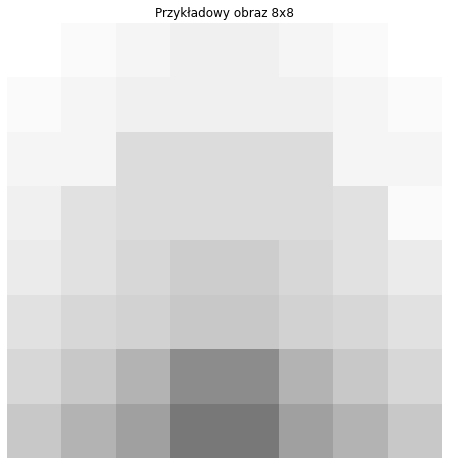

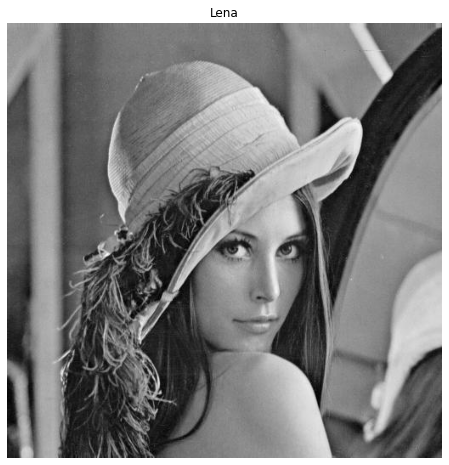

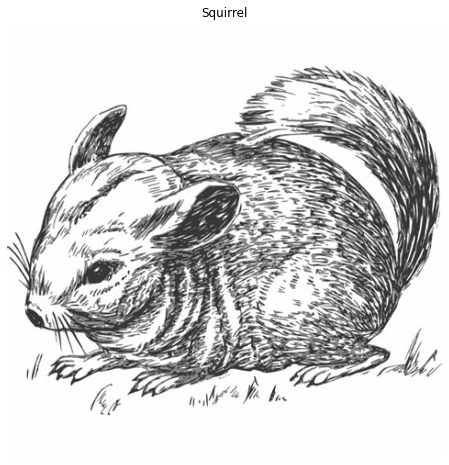

In [72]:
def read_file(name):
    file = open(name, 'r')
    size = file.readline().split(' ')
    size_x = np.uint8(size[0])
    size_y = np.uint8(size[1])

    img = np.zeros((size_x, size_y))
    for x in range(size_x):
        line = file.readline().split(' ')
        for y in range(size_y):
            img[x][y] = int(line[y])

    file.close()
    return img

lena = pil.Image.open('lena.jpg')
squirrel = pil.Image.open('squirrel.png')
img = read_file("input_img_1.txt")

rcParams['figure.figsize'] = [8, 8]

figure(1)
axis('off')
title('Przykładowy obraz 8x8')
img = np.array(img, dtype=np.uint8)
imshow(img, cmap='gray', vmin='0', vmax='255')

figure(2)
axis('off')
lena = np.array(lena, dtype=np.uint8)
title('Lena')
imshow(lena, cmap='gray', vmin='0', vmax='255')

figure(3)
axis('off')
squirrel = np.array(squirrel, dtype=np.uint8)
title('Squirrel')
imshow(squirrel, cmap='gray', vmin='0', vmax='255')

Do wykonania kompresji niezbędna jest macierz kwantyzacji. W tym wypadku wykorzystana jest standardowa macierz kwantyzacji IJG (independent JPEG Group).

In [73]:
file = open("quantization_table_N.txt", 'r')
q_table_N = zeros((8, 8))
for i in range(8):
    line = file.readline().split(' ')
    for j in range(8):
        q_table_N[i][j] = int(line[j])
    
file.close()
q_table_N = np.array(q_table_N, dtype=np.uint8)
print(q_table_N)

[[ 16  11  10  16  24  40  51  61]
 [ 12  12  14  19  26  58  60  55]
 [ 14  13  16  24  40  57  69  56]
 [ 14  17  22  29  51  87  80  62]
 [ 18  22  37  56  68 109 103  77]
 [ 24  35  55  64  81 104 113  92]
 [ 49  64  78  87 103 121 120 101]
 [ 72  92  95  98 112 100 103  99]]


W celu modyfikacji macierzy wprowadzony został współczynnik jakości (z przedziału od 1 do 100). Im  większy współczynnik tym mniejsze współczynniki w macierzy kwantyzacji i większa jakość obrazu po kompresji.

In [74]:
q_factor = 20
if q_factor < 50:
    S = np.floor(5000 / q_factor)
else:
    S = np.floor(200 - 2 * q_factor)

q_table = zeros((8, 8))

for i in range(8):
    for j in range(8):
        q_table[i][j] = np.floor((S * q_table_N[i][j] + 50) / 100)

print(q_table)

# temp = 64*[0]
# for i in range(len(q_table)):
#     for j in range(len(q_table[0])):
#         temp[i*8 +j] = int(q_table[i][j])
# print(temp)

[[ 40.  28.  25.  40.  60. 100. 128. 153.]
 [ 30.  30.  35.  48.  65. 145. 150. 138.]
 [ 35.  33.  40.  60. 100. 143. 173. 140.]
 [ 35.  43.  55.  73. 128. 218. 200. 155.]
 [ 45.  55.  93. 140. 170. 273. 258. 193.]
 [ 60.  88. 138. 160. 203. 260. 283. 230.]
 [123. 160. 195. 218. 258. 303. 300. 253.]
 [180. 230. 238. 245. 280. 250. 258. 248.]]


Wykonanie transformacji cosinusowej

In [75]:
img_DCT = fftpack.dctn(img, norm='ortho')
img_DCT = np.array(img_DCT, dtype=np.float16)
print(img_DCT)

[[ 1.7320e+03 -1.7334e+00  1.0594e+02 -1.4697e+00 -5.0000e+00 -9.8193e-01
   7.5312e+00 -3.4497e-01]
 [ 2.0275e+02 -4.7827e-01 -5.8125e+01 -4.0552e-01  1.7141e+01 -2.7100e-01
  -1.4852e+01 -9.5154e-02]
 [-5.5188e+01  2.2656e+00  2.4656e+01  1.9209e+00 -1.5773e+01  1.2832e+00
   6.2500e+00  4.5068e-01]
 [ 4.6812e+01  1.3623e+00 -2.2875e+01  1.1553e+00 -1.1835e-01  7.7148e-01
   4.8047e+00  2.7100e-01]
 [-1.2500e+01 -1.7334e+00  2.8711e+00 -1.4697e+00  5.0000e+00 -9.8193e-01
   6.9297e+00 -3.4497e-01]
 [-4.0664e+00 -2.0391e+00  1.2016e+01 -1.7285e+00 -5.9473e-01 -1.1553e+00
   1.6650e+00 -4.0552e-01]
 [ 3.9238e+00  9.3848e-01 -6.2500e+00  7.9541e-01  1.1211e+00  5.3174e-01
  -7.1602e+00  1.8665e-01]
 [-1.1266e+01  2.4043e+00  1.8250e+01  2.0391e+00 -1.1445e+01  1.3623e+00
  -7.0234e+00  4.7827e-01]]


Kwantyzacja - początek stratnej części kompresji. Wartości współczynników transformacji cosinusowej są dzielone bez reszty przez współczynniki z macierzy kwantyzacji. Po tym etapie mogą nastąpić dalsze czynności w celu zapisania pliku jednak w tym przypadku chodzi o pokazanie efektów stratnej kompresji, więc zostanie to pominięte.

In [76]:
for i in range(len(img_DCT)):
    for j in range(len(img_DCT[0])):
        img_DCT[i][j] = np.int16(img_DCT[i][j] / q_table[i][j])

img_DCT = np.array(img_DCT, dtype=np.int16)
print(img_DCT)

[[43  0  4  0  0  0  0  0]
 [ 6  0 -1  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


Odwrócenie kwantyzacji - po kompresji, w celu przywrócenia obrazu wykonuje się mnożenie skwantowanych wartości przez współczynniki z macierzy kwantyzacji.

In [77]:
for i in range(len(img_DCT)):
    for j in range(len(img_DCT[0])):
        img_DCT[i][j] = img_DCT[i][j] * q_table[i][j]

print(img_DCT)

[[1720    0  100    0    0    0    0    0]
 [ 180    0  -35    0    0    0    0    0]
 [ -35    0    0    0    0    0    0    0]
 [  35    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]


Wykonanie odwrotnej transformacji cosinusowej

In [78]:
img_IDCT = fftpack.idctn(img_DCT, norm='ortho')
img_IDCT = np.array(img_IDCT, dtype=np.uint8)
print(img_IDCT)


[[254 249 242 237 237 242 249 254]
 [247 241 233 228 228 233 241 247]
 [240 233 224 217 217 224 233 240]
 [238 229 217 208 208 217 229 238]
 [235 225 210 200 200 210 225 235]
 [226 214 197 184 184 197 214 226]
 [210 196 177 164 164 177 196 210]
 [197 182 162 148 148 162 182 197]]


Obraz po odwróceniu transformacji jest zapiswany do pliku i wyświetlany.

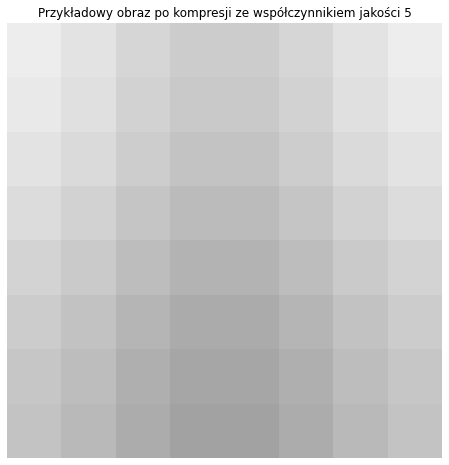

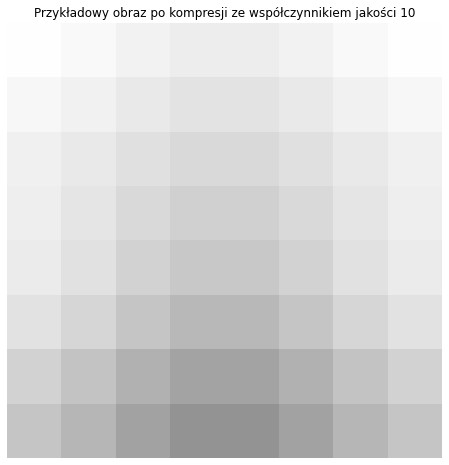

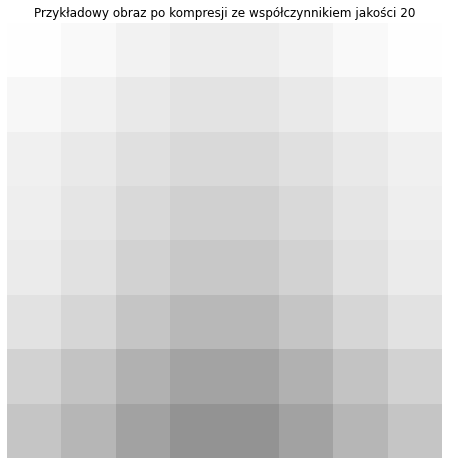

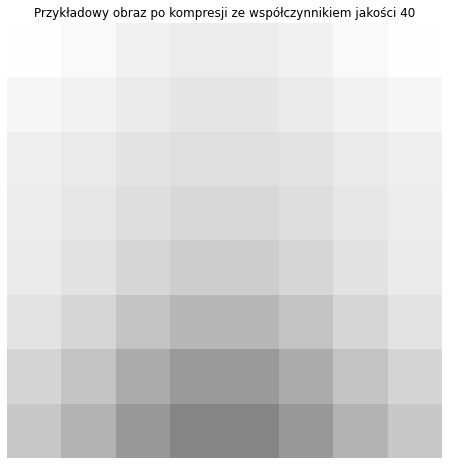

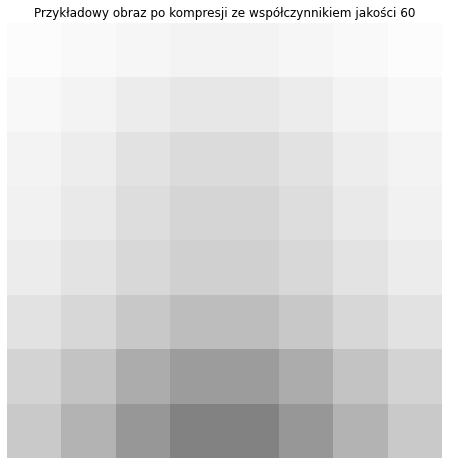

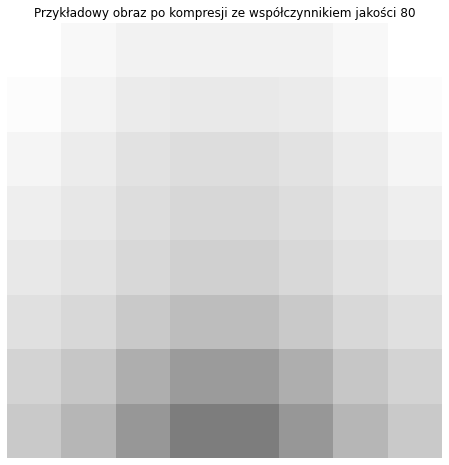

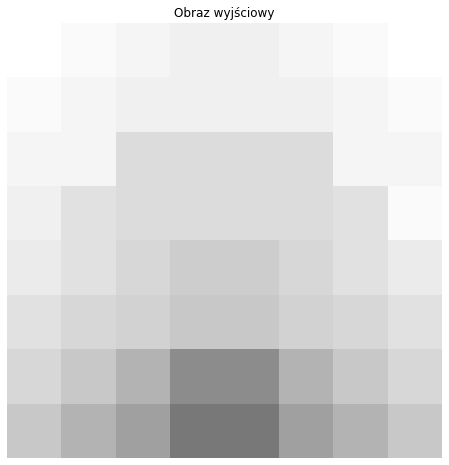

In [79]:
file = open("output_img_10.txt", 'w')
file.write("8 8\n")
for i in range(len(img_IDCT)):
    for j in range(len(img_IDCT[0])):
        file.write(str(img_IDCT[i][j]) + ' ')
    file.write('\n')
file.close()

figure(1)
axis('off')
title('Przykładowy obraz po kompresji ze współczynnikiem jakości 5')
img = read_file("output_img_5.txt")
imshow(img, cmap='gray', vmin='0', vmax='255')

figure(2)
axis('off')
title('Przykładowy obraz po kompresji ze współczynnikiem jakości 10')
img = read_file("output_img_10.txt")
imshow(img, cmap='gray', vmin='0', vmax='255')

figure(3)
axis('off')
title('Przykładowy obraz po kompresji ze współczynnikiem jakości 20')
img = read_file("output_img_20.txt")
imshow(img, cmap='gray', vmin='0', vmax='255')

figure(4)
axis('off')
title('Przykładowy obraz po kompresji ze współczynnikiem jakości 40')
img = read_file("output_img_40.txt")
imshow(img, cmap='gray', vmin='0', vmax='255')

figure(5)
axis('off')
title('Przykładowy obraz po kompresji ze współczynnikiem jakości 60')
img = read_file("output_img_60.txt")
imshow(img, cmap='gray', vmin='0', vmax='255')

figure(6)
axis('off')
title('Przykładowy obraz po kompresji ze współczynnikiem jakości 80')
img = read_file("output_img_80.txt")
imshow(img, cmap='gray', vmin='0', vmax='255')

figure(7)
axis('off')
title('Obraz wyjściowy')
img = read_file('input_img_1.txt')
imshow(img, cmap='gray', vmin='0', vmax='255')

W tym miejscu dokonywana jest kompresja obrazów lena oraz squirrel przy użyciu macierzy kwantyzacji obliczonych dla współczynników 5, 10, 20, 40, 60, 80, 100

In [80]:

lena.save('lena_quality_5.jpg', quality='quality_5')
lena.save('lena_quality_10.jpg', quality='quality_10')
lena.save('lena_quality_20.jpg', quality='quality_20')
lena.save('lena_quality_40.jpg', quality='quality_40')
lena.save('lena_quality_60.jpg', quality='quality_60')
lena.save('lena_quality_80.jpg', quality='quality_80')
lena.save('lena_quality_100.jpg', quality='web_maximum')

squirrel.save('squirrel_quality_5.jpg', quality='quality_5')
squirrel.save('squirrel_quality_10.jpg', quality='quality_10')
squirrel.save('squirrel_quality_20.jpg', quality='quality_20')
squirrel.save('squirrel_quality_40.jpg', quality='quality_40')
squirrel.save('squirrel_quality_60.jpg', quality='quality_60')
squirrel.save('squirrel_quality_80.jpg', quality='quality_80')
squirrel.save('squirrel_quality_100.jpg', quality='web_maximum')

AttributeError: 'numpy.ndarray' object has no attribute 'save'

Wyświetlenie obrazów po kompresji

Obraz po kompresji ze współczynnikiem jakości 5

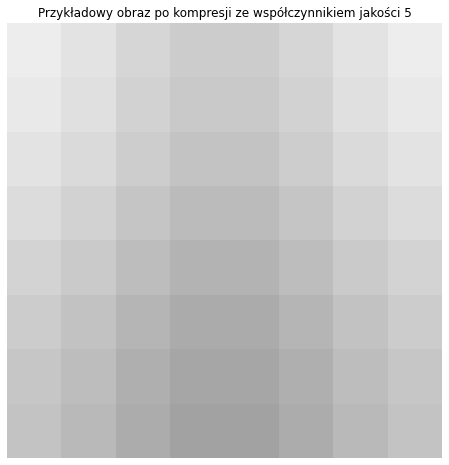

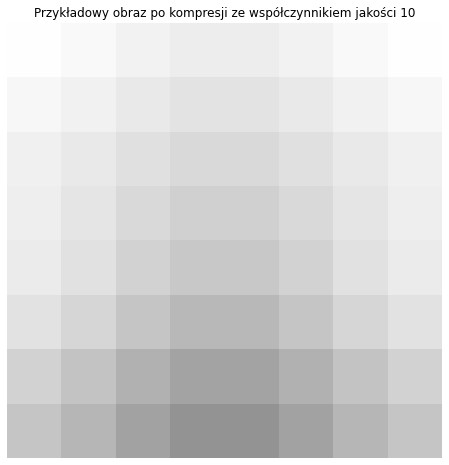

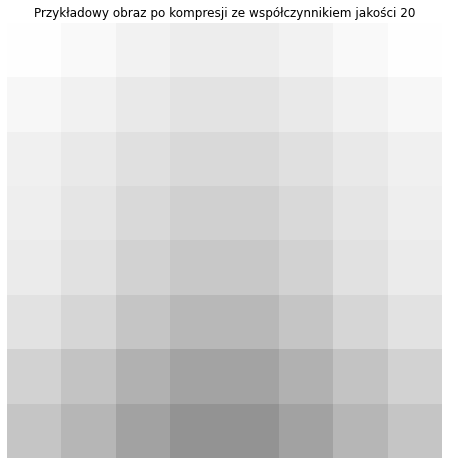

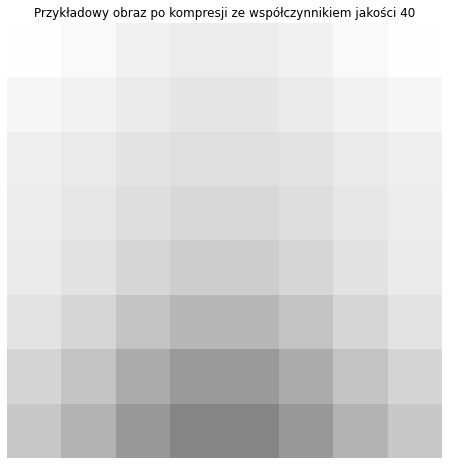

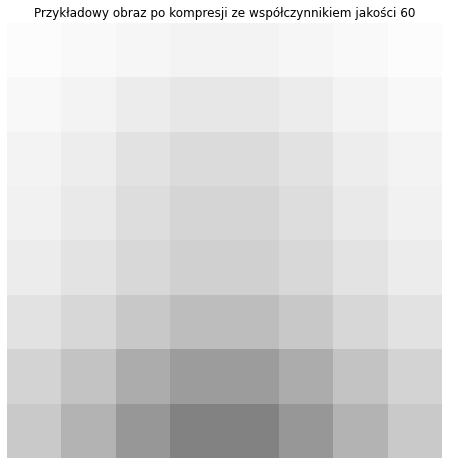

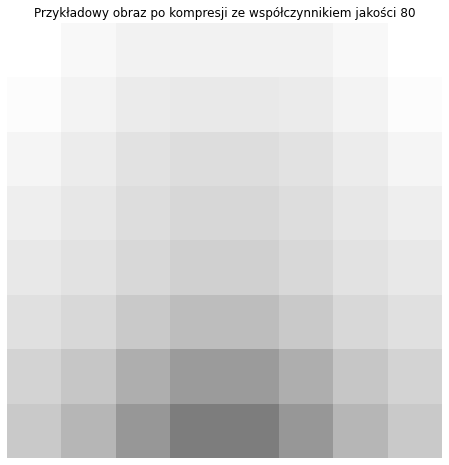

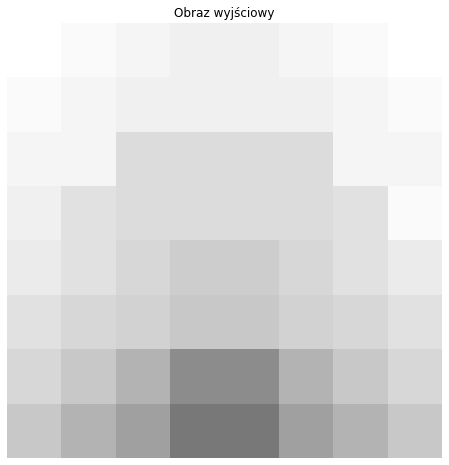